<a href="https://colab.research.google.com/github/fnavab/APS360-project/blob/main/Final_Alex_ANN_84__30min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt


**Only Run the following if you don't have the features of AlexNet**

In [ ]:
import torchvision.models
import os
alexnet = torchvision.models.alexnet(pretrained=True)

# initialize path
feature_path = '/content/gdrive/My Drive/Colab Notebooks/combined_features'

# Prepare Dataloader 
dataset= get_data()
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']
train_loader, val_loader, test_loader=get_data_loader(classes=classes, batchsize=1, dataset=dataset)


save_features(train_loader,"train",feature_path, classes=classes)
save_features(val_loader,"val",feature_path, classes=classes)
save_features(test_loader,"test",feature_path, classes=classes)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



train features saved
val features saved
test features saved


In [5]:
def get_alex_data_loader(batch_size):
  train_dir = '/content/gdrive/My Drive/Colab Notebooks/combined_features/train'
  test_dir = '/content/gdrive/My Drive/Colab Notebooks/combined_features/test'
  val_dir = '/content/gdrive/My Drive/Colab Notebooks/combined_features/val'
  train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.tensor'))
  val_set= torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.tensor'))
  test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.tensor'))
  torch.manual_seed(1) # set the random seed

  num_workers = 1
  train_feature_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  test_feature_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  val_feature_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)


  return train_feature_loader, test_feature_loader,val_feature_loader

In [6]:
#Prepare feature loader
train_feature_loader, test_feature_loader,val_feature_loader=get_alex_data_loader(64)

In [5]:
# Verification Step - obtain one batch of features
dataiter = iter(val_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([64, 256, 8, 8])
torch.Size([64])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_ALEX(nn.Module):
    def __init__(self):
        super(CNN_ALEX, self).__init__()
        self.name="CNN_ALEX"
        # self.conv = nn.Conv2d(256, 10, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv(x)))

        x = x.view(x.shape[0], 256 * 8 * 8) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [8]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [9]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [10]:
def train_net(model,target_classes,train_loader,val_loader, batch_size=64, learn_rate=0.001, num_epochs=30):
    ########################################################################
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy,which will apply softmax to the output layer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time=time.time()
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for imgs, labels in iter(train_loader):

            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            # Forward pass, backward pass, and optimize
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_loss[epoch] = float(total_train_loss) / (batch_size)
        train_acc[epoch]= get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch]
                   ))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')

    end_time= time.time()

    # Write the train/test loss/err into CSV file 
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time: " , (end_time-start_time))


    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

TO DO: Hyper parameter tuning

Epoch 1: Train acc: 0.7649765798340045, Train loss: 3.042903191410005 |Validation acc: 0.7029081295439524
Epoch 2: Train acc: 0.8257046593803928, Train loss: 1.9593640938401222 |Validation acc: 0.751487111698612
Epoch 3: Train acc: 0.8640808612047005, Train loss: 1.520719570107758 |Validation acc: 0.7653668208856577
Epoch 4: Train acc: 0.8825704659380392, Train loss: 1.205912807257846 |Validation acc: 0.7683410442828817
Epoch 5: Train acc: 0.914372586079382, Train loss: 1.0059801146853715 |Validation acc: 0.7855254461335096
Epoch 6: Train acc: 0.8991700221875257, Train loss: 0.8121624325867742 |Validation acc: 0.7706543291473893
Epoch 7: Train acc: 0.9528309639247268, Train loss: 0.6169582582078874 |Validation acc: 0.8040317250495704
Epoch 8: Train acc: 0.9668830635220642, Train loss: 0.5359998470521532 |Validation acc: 0.8139458030403173
Epoch 9: Train acc: 0.9654038951433972, Train loss: 0.4110717116855085 |Validation acc: 0.8086582947785856
Epoch 10: Train acc: 0.9577615251869505, T

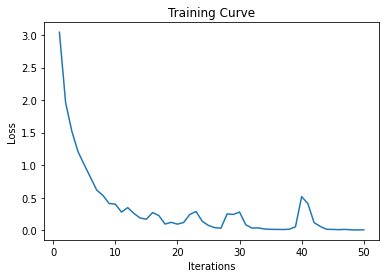

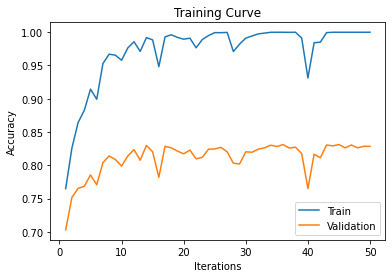

In [13]:
use_cuda = True
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']

model=CNN_ALEX()
if use_cuda and torch.cuda.is_available():
    model.cuda()
train_net(model, classes,train_feature_loader, val_feature_loader, batch_size=64, num_epochs=50, learn_rate = 0.001)

In [19]:
torch.save(model.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/Final-Model")

In [20]:
model.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/Final-Model"))

<All keys matched successfully>

In [ ]:
get_accuracy(model,train_feature_loader)

0.9996712959158518

In [16]:
get_accuracy(model,test_feature_loader)

0.8356573705179283

In [21]:
def get_confusion_matrix(model, data_loader):
    correct = 0
    total = 0
    nb_classes = 8

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():

      for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        
        for t, p in zip(labels.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    # Visualize it as a heatmap
    import seaborn
    seaborn.heatmap(confusion_matrix)
    plt.show()

tensor([[341.,   8.,   2.,   1.,  12.,   0.,  11.,   5.],
        [  7., 324.,   2.,   4.,  16.,   1.,   2.,  18.],
        [  2.,   2., 328.,  38.,   0.,   4.,   4.,   1.],
        [  3.,   1.,  40., 308.,   1.,  12.,   8.,   2.],
        [ 12.,  17.,   1.,   3., 297.,   4.,   1.,  30.],
        [  1.,   2.,   9.,  10.,   3., 329.,  47.,   1.],
        [  6.,   9.,   6.,   9.,   3.,  32., 290.,   7.],
        [  8.,  34.,   0.,   1.,  22.,   5.,   5., 300.]])
tensor([0.8974, 0.8663, 0.8654, 0.8213, 0.8137, 0.8184, 0.8011, 0.8000])


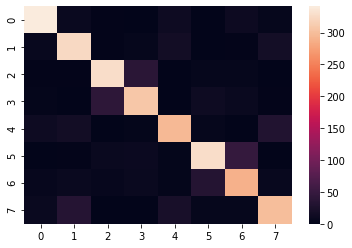

In [23]:
get_confusion_matrix(model,test_feature_loader)